In [26]:
from sklearn.externals import joblib
from sklearn import metrics
import os
import numpy
import matplotlib.pyplot as plt
import pandas as pd
import math
import matplotlib
import datetime
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
matplotlib.style.use('ggplot')
%matplotlib inline

pd.set_option('precision',8)

In [27]:
os.getcwd()

'/home/cataclysmic/Research/crypto/src/exploration'

In [28]:
df = joblib.load('../../bld/out/data_processed/BTC_POT_trade_history.p.lzma')

In [29]:

# reducing dataset to buy only as those drive prices
df = df.query('BTC_POT_TYPE == "buy"')
#df['BTC_POT_TYPE'] = df['BTC_POT_TYPE'].astype('category')
df['tvalue'] = df.index
df['deltat'] = (df['tvalue']-df['tvalue'].shift(1)) #.total_seconds()

#remove if where quoteVolume = 0
#df = df[df.quoteVolume != 0]
df['tvalue'] = df.index
df['deltat'] = (df['tvalue'].shift(1)-df['tvalue'])
df['deltat'] = df['deltat'].astype('timedelta64')
for i in range(1,11):
    df['BTC_POT_RATE_'+str(i)] = df["BTC_POT_RATE"].shift(i)
for i in range(1,11):
    df['BTC_POT_TOTAL_'+str(i)] = df["BTC_POT_TOTAL"].shift(i)
# create binaries
#df['sell'] = pd.get_dummies(df['BTC_POT_TYPE'])['sell']

# remove time helper and AMOUNT
# Total = multiplied result of AMOUNT and Rate
df = df.drop(['tvalue','BTC_POT_AMOUNT','BTC_POT_TYPE'],1)



In [30]:
# create pot rate difference for dependent variable
df['ratechange'] = df['BTC_POT_RATE'] - df['BTC_POT_RATE'].shift(1)
# !! IMPORTANT outcome variable is the LAST in df

In [31]:
df

,BTC_POT_RATE,BTC_POT_TOTAL,deltat,BTC_POT_RATE_1,BTC_POT_RATE_2,BTC_POT_RATE_3,BTC_POT_RATE_4,BTC_POT_RATE_5,BTC_POT_RATE_6,BTC_POT_RATE_7,...,BTC_POT_TOTAL_2,BTC_POT_TOTAL_3,BTC_POT_TOTAL_4,BTC_POT_TOTAL_5,BTC_POT_TOTAL_6,BTC_POT_TOTAL_7,BTC_POT_TOTAL_8,BTC_POT_TOTAL_9,BTC_POT_TOTAL_10,ratechange
date,,,,,,,,,,,,,,,,,,,,,
2015-01-31 20:46:53,0.00000657,0.05789412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-31 20:46:53,0.00000656,0.09643437,0.00000000e+00,0.00000657,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00000000e-08
2015-01-31 20:22:20,0.00000656,0.00065873,1.47300000e+12,0.00000656,0.00000657,NaN,NaN,NaN,NaN,NaN,...,0.05789412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000000e+00
2015-01-31 20:21:47,0.00000656,0.00063436,3.30000000e+10,0.00000656,0.00000656,0.00000657,NaN,NaN,NaN,NaN,...,0.09643437,0.05789412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00000000e+00
2015-01-31 20:21:13,0.00000656,0.00012074,3.40000000e+10,0.00000656,0.00000656,0.00000656,0.00000657,NaN,NaN,NaN,...,0.00065873,0.09643437,0.05789412,NaN,NaN,NaN,NaN,NaN,NaN,0.00000000e+00
2015-01-31 20:03:06,0.00000656,0.00010001,1.08700000e+12,0.00000656,0.00000656,0.00000656,0.00000656,0.00000657,NaN,NaN,...,0.00063436,0.00065873,0.09643437,0.05789412,NaN,NaN,NaN,NaN,NaN,0.00000000e+00
2015-01-31 20:02:50,0.00000656,0.00133792,1.60000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000657,NaN,...,0.00012074,0.00063436,0.00065873,0.09643437,0.05789412,NaN,NaN,NaN,NaN,0.00000000e+00
2015-01-31 19:56:24,0.00000656,0.00010001,3.86000000e+11,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000657,...,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437,0.05789412,NaN,NaN,NaN,0.00000000e+00
2015-01-31 19:55:44,0.00000656,0.00010001,4.00000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437,0.05789412,NaN,NaN,0.00000000e+00


In [33]:
df.dropna(axis=0,how="any")

,BTC_POT_RATE,BTC_POT_TOTAL,deltat,BTC_POT_RATE_1,BTC_POT_RATE_2,BTC_POT_RATE_3,BTC_POT_RATE_4,BTC_POT_RATE_5,BTC_POT_RATE_6,BTC_POT_RATE_7,...,BTC_POT_TOTAL_2,BTC_POT_TOTAL_3,BTC_POT_TOTAL_4,BTC_POT_TOTAL_5,BTC_POT_TOTAL_6,BTC_POT_TOTAL_7,BTC_POT_TOTAL_8,BTC_POT_TOTAL_9,BTC_POT_TOTAL_10,ratechange
date,,,,,,,,,,,,,,,,,,,,,
2015-01-31 19:54:39,0.00000656,0.00010001,2.90000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437,0.05789412,0.00000000e+00
2015-01-31 19:47:14,0.00000656,0.00010001,4.45000000e+11,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437,0.00000000e+00
2015-01-31 19:46:49,0.00000656,0.00040152,2.50000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.00000000e+00
2015-01-31 19:46:30,0.00000656,0.00039011,1.90000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00000000e+00
2015-01-31 19:46:03,0.00000656,0.00010001,2.70000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00000000e+00
2015-01-31 19:45:51,0.00000656,0.00040203,1.20000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00000000e+00
2015-01-31 19:29:40,0.00000656,0.00010001,9.71000000e+11,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00000000e+00
2015-01-31 19:29:15,0.00000656,0.00038809,2.50000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00040203,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00000000e+00
2015-01-31 19:28:53,0.00000656,0.00010001,2.20000000e+10,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,...,0.00010001,0.00040203,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00000000e+00


In [8]:
# reduce dataset in sze for testing
REDUCE = 5000

# removing all NaNs
df = df[numpy.isfinite(df['BTC_POT_RATE_10'])]
# remove first 3 vars RATE TOTAL deltat
'''Reduce sice - necessary because original df is too big for my little notebook'''
df = df.iloc[0:REDUCE,:]
dfOut = df.iloc[:,-1]
df = df.iloc[:,3:-1]

In [9]:
df

,BTC_POT_RATE_1,BTC_POT_RATE_2,BTC_POT_RATE_3,BTC_POT_RATE_4,BTC_POT_RATE_5,BTC_POT_RATE_6,BTC_POT_RATE_7,BTC_POT_RATE_8,BTC_POT_RATE_9,BTC_POT_RATE_10,BTC_POT_TOTAL_1,BTC_POT_TOTAL_2,BTC_POT_TOTAL_3,BTC_POT_TOTAL_4,BTC_POT_TOTAL_5,BTC_POT_TOTAL_6,BTC_POT_TOTAL_7,BTC_POT_TOTAL_8,BTC_POT_TOTAL_9,BTC_POT_TOTAL_10
date,,,,,,,,,,,,,,,,,,,,
2015-01-31 19:54:39,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000657,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437,0.05789412
2015-01-31 19:47:14,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873,0.09643437
2015-01-31 19:46:49,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436,0.00065873
2015-01-31 19:46:30,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074,0.00063436
2015-01-31 19:46:03,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001,0.00012074
2015-01-31 19:45:51,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792,0.00010001
2015-01-31 19:29:40,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00040203,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001,0.00133792
2015-01-31 19:29:15,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00010001,0.00040203,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001,0.00010001
2015-01-31 19:28:53,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00000656,0.00038809,0.00010001,0.00040203,0.00010001,0.00039011,0.00040152,0.00010001,0.00010001,0.00017104,0.00010001


In [10]:
dfOut

date
2015-01-31 19:54:39    0.00000000e+00
2015-01-31 19:47:14    0.00000000e+00
2015-01-31 19:46:49    0.00000000e+00
2015-01-31 19:46:30    0.00000000e+00
2015-01-31 19:46:03    0.00000000e+00
2015-01-31 19:45:51    0.00000000e+00
2015-01-31 19:29:40    0.00000000e+00
2015-01-31 19:29:15    0.00000000e+00
2015-01-31 19:28:53    0.00000000e+00
2015-01-31 19:10:37    0.00000000e+00
2015-01-31 19:10:02    0.00000000e+00
2015-01-31 19:09:36    0.00000000e+00
2015-01-31 18:52:58    0.00000000e+00
2015-01-31 18:52:20    0.00000000e+00
2015-01-31 18:52:05    0.00000000e+00
2015-01-31 18:51:55    0.00000000e+00
2015-01-31 18:51:35    0.00000000e+00
2015-01-31 18:51:08    0.00000000e+00
2015-01-31 18:50:31    0.00000000e+00
2015-01-31 18:49:55    0.00000000e+00
2015-01-31 18:49:46    0.00000000e+00
2015-01-31 18:49:22    0.00000000e+00
2015-01-31 18:48:54    0.00000000e+00
2015-01-31 18:48:25    0.00000000e+00
2015-01-31 18:47:50    0.00000000e+00
2015-01-31 18:47:30    0.00000000e+00
2015-01

In [11]:
'''Rescale dataset for gradient decend'''
scaler = MinMaxScaler(feature_range=(-1,1))
ds = scaler.fit_transform(df)

In [12]:
'''Create training and test set'''
traini = int(len(ds) * 0.67)
testi = traini + 1

# define how many vars to use
whichVars = 5

trainRChange = dfOut.iloc[0:traini]
trainX = ds[:traini,:whichVars]

testRChange = dfOut.iloc[testi:]
testX = ds[testi:,:whichVars]

ds

array([[-0.59185304, -0.59185304, -0.59185304, ..., -0.99981906,
        -0.97351202, -0.98409801],
       [-0.59185304, -0.59185304, -0.59185304, ..., -0.99982576,
        -0.99981906, -0.97351202],
       [-0.59185304, -0.59185304, -0.59185304, ..., -0.99996684,
        -0.99982576, -0.99981906],
       ..., 
       [-0.70527157, -0.70527157, -0.69089457, ..., -0.99993719,
        -0.99992631, -0.99995334],
       [-0.70527157, -0.70527157, -0.70527157, ..., -0.99996585,
        -0.99993719, -0.99992631],
       [-0.70527157, -0.70527157, -0.70527157, ..., -0.99996591,
        -0.99996585, -0.99993719]])

In [13]:
len(trainRChange)

3350

In [14]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [16]:
arimadfR = dfOut

from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(arimadfR, order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

'''ARIMA model does not converge in terms of rate
But converges for Amount
'''


/home/cataclysmic/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:466: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:           D.ratechange   No. Observations:                 4999
Model:                 ARIMA(5, 1, 0)   Log Likelihood               63781.451
Method:                       css-mle   S.D. of innovations              0.000
Date:                Thu, 30 Mar 2017   AIC                        -127548.901
Time:                        15:39:14   BIC                        -127503.282
Sample:                    01-31-2015   HQIC                       -127532.912
                         - 07-18-2015                                         
                         coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
const               1.939e-23   9.81e-09   1.98e-15      1.000     -1.92e-08  1.92e-08
ar.L1.D.ratechange    -0.9519      0.014    -68.307      0.000        -0.979    -0.925
ar.L2.D.ratechange  

'ARIMA model does not converge in terms of rate\nBut converges for Amount\n'

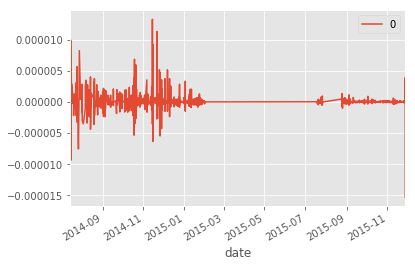

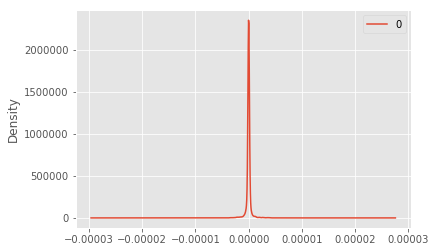

                    0
count  4.99900000e+03
mean  -1.33898715e-11
std    6.96079122e-07
min   -1.53200000e-05
25%   -3.03809167e-08
50%   -7.38655206e-23
75%    2.67712052e-08
max    1.32713816e-05


In [17]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [18]:
# create and fit the LSTM network

''' Variables to include '''
# DIMS = len(trainX)
DIMS = 5
''' Iterations to run '''
EPOCHS = 10

modelR = Sequential()
modelR.add(LSTM(4, input_shape=(None,DIMS)))
modelR.add(Dense(1))
modelR.compile(loss='mean_squared_error', optimizer='adam')
modelR.fit(trainX, trainRChange, epochs=EPOCHS, batch_size=1, verbose=2)

# make predictions
trainPredictR = modelR.predict(trainX)
testPredictR = modelR.predict(testX)


################## up to here then pipeline into scorer

Epoch 1/10
18s - loss: 1.1507e-04
Epoch 2/10
29s - loss: 1.7342e-06
Epoch 3/10
42s - loss: 4.4280e-07
Epoch 4/10
43s - loss: 3.8750e-07
Epoch 5/10
37s - loss: 3.5060e-07
Epoch 6/10
22s - loss: 2.4868e-07
Epoch 7/10
20s - loss: 3.7374e-07
Epoch 8/10
24s - loss: 2.1296e-07
Epoch 9/10
20s - loss: 4.2924e-07
Epoch 10/10
23s - loss: 3.5009e-07


In [19]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainRChange, trainPredictR))
print('Train Score: %.10f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testRChange, testPredictR))
print('Test Score: %.10f RMSE' % (testScore))

Train Score: 0.0002342946 RMSE
Test Score: 0.0004477080 RMSE


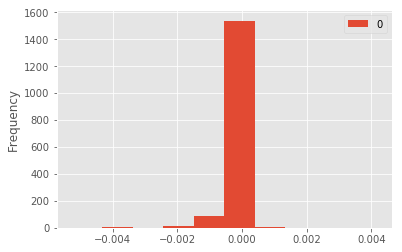

In [24]:
plotly = pd.DataFrame(testPredictR,testRChange)

plotly.plot(kind="hist")

In [ ]:
# create buying and selling triggers
def trigger_generator(row):
    if row['ratechange'] < 0:
        return -1
    elif row['ratechange'] > 0:
        return 1
    else:
        return 0

df['buyer'] = df.apply(lambda row: trigger_generator (row),axis=1)

df.dtypes

In [ ]:
trainPredSell = numpy.where(trainPredictR < 0,1,0)
trainSell = numpy.where(trainRChange < 0,1,0)

testPredSell = numpy.where(testPredictR < 0,1,0)
testSell = numpy.where(testRChange < 0,1,0)

In [ ]:
trainRChange

In [ ]:
# calculate the fpr and tpr for all thresholds of the classification
fpr, tpr, threshold = metrics.roc_curve(testSell, testPredSell)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()